# US Dept of Education - College Scorecard

## Questions
### 1. Given ACT score in English, writing and Math, what are your expected earning income after you graduate?
### 2. Does studying in public college earns more than studying in private college?
### 3. Does tuition fee affect the income of graduate?
### 4. Does SAT score affect the income of graduate?
### 5. Which sector of ACT scores contributes the most to the income of graduate?

# Libraries and modules imported

In [711]:
import pandas as pd
import numpy as np
import sqlite3 
import math
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Extracting data from the database file

The database file and the College Scorecard.csv are the same, we will be using the database file to extract features that will be useful in our data analysis.

In [671]:
con = sqlite3.connect('output/database.sqlite')
data = pd.read_sql('SELECT UNITID, INSTNM, cast(SAT_AVG as int)SAT_AVG, cast(ACTENMID as int)ACTENMID, cast(ACTMTMID as int)ACTMTMID,\
                  cast(ACTWRMID as int)ACTWRMID, cast(TUITIONFEE_PROG as int)TUITIONFEE_PROG, cast(MD_EARN_WNE_P10 as int)MD_EARN_WNE_P10,\
                  cast(UNEMP_RATE as int) UNEMP_RATE, cast(MD_EARN_WNE_P6 as int)MD_EARN_WNE_P6, cast(ADM_RATE as int) ADM_RATE,\
                  cast(TUITIONFEE_IN as int) TUITIONFEE_IN,cast(TUITIONFEE_OUT as int) TUITIONFEE_OUT, CONTROL,STABBR from Scorecard', con)
df_copy = data.copy()

# Exploratory data analysis
Before jumping into data analysis, we must first have a thorough understanding of our data. <br>
First, we take a look at a brief summary of our data.

In [717]:
df_copy.head(3)

,UNITID,INSTNM,SAT_AVG,ACTENMID,ACTMTMID,ACTWRMID,TUITIONFEE_PROG,MD_EARN_WNE_P10,UNEMP_RATE,MD_EARN_WNE_P6,ADM_RATE,TUITIONFEE_IN,TUITIONFEE_OUT,CONTROL,STABBR
79898,100858,Auburn University Main Campus,1166.0,27.0,25.0,8.0,NaN,NaN,NaN,NaN,0.0,6500.0,18260.0,Public,AL
79914,101480,Jacksonville State University,920.0,20.0,19.0,24.0,NaN,NaN,NaN,NaN,0.0,4560.0,9120.0,Public,AL
79939,102234,Spring Hill College,1090.0,25.0,23.0,8.0,NaN,NaN,NaN,NaN,0.0,24240.0,24240.0,Private nonprofit,AL


In [672]:
df_copy.describe()

,UNITID,SAT_AVG,ACTENMID,ACTMTMID,ACTWRMID,TUITIONFEE_PROG,MD_EARN_WNE_P10,UNEMP_RATE,MD_EARN_WNE_P6,ADM_RATE,TUITIONFEE_IN,TUITIONFEE_OUT
count,1.246990e+05,18598.000000,13222.000000,13207.000000,1445.000000,30782.000000,19311.000000,32337.000000,32688.000000,34156.000000,58024.000000,56844.000000
mean,6.929501e+05,1052.701043,22.316669,21.994018,10.215225,11574.881132,29575.133344,3.337292,25054.084068,0.106043,10587.185768,12616.974632
std,3.599043e+06,126.892749,3.548055,3.290569,14.849524,6614.404962,17312.794769,1.383665,14172.591658,0.312428,8856.046236,8138.403437
min,1.006360e+05,514.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.606670e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.083180e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.800940e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4.828571e+07,1599.000000,36.000000,35.000000,530.000000,88550.000000,250000.000000,15.000000,133600.000000,10.000000,70024.000000,70024.000000


By looking at the output of .describe(), we can make a few conclusion that.

A lot of features have missing values, this conclusion is drawn by looking at the _count_ output. <br>
Furthermore by looking at the min values of variables like MD_EARN_WNE_P6 and ADM_RATE, which is zero which are logically wrong. <br> <br>
By looking further into the data, we can see that a lot of our data are missing (Labeled NaN). 
Unfortunately, running the dropna() command on the dataframe results in loss of <b>all</b> data as each row has at least one or two missing values. Hence data cleaning will be performed individually when we want to use the data.
<hr>

## Descriptive Statistics

For each of the numerical variables, a histogram will be plotted out to see the distribution of data as well as to identify any outliers present in the variable. For non-numerical variables, barplots will be used.

We take a look at the distribution of the data to better understand our data as well as to make conclusions on data. For instance, we can find out the similarities between the data or where most of the data converge as just looking at the mean value sometimes is not accurate enough since mean can be easily affected by outliers.

For each of the graph, a short description of the data is printed out (max value, min value, standard deviation et cetera), as well as the variance of the data.<br> Variance very close to zero means that most of the data are similiar, while high variance often mean that most data is distinct. Hence by taking the variance value into consideration, we can remove features that carry little information. Important thing to note is that the data needs to be normalized before finding the variance.

In [714]:
min_max_scaler = preprocessing.MinMaxScaler() #For normalization
# Clean NaN values from the variable we want to check
def cleanVariable(variable_to_check):
    df_SAT = df_copy.copy()
    #df_SAT = df_SAT[~np.isnan(df_SAT[variable_to_check])] #Remove NaN values
    df_SAT = df_SAT[df_SAT[variable_to_check]>0]
    return df_SAT

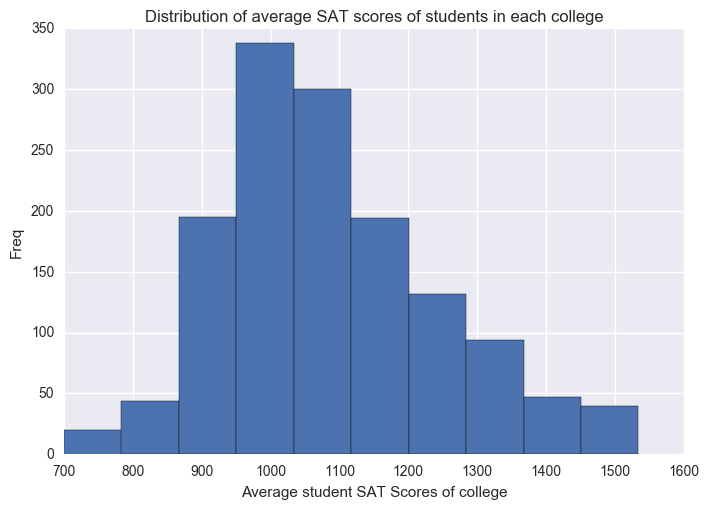

Variance:  0.0359181807255
count    1404.000000
mean     1087.503561
std       158.116770
min       700.000000
25%       973.000000
50%      1065.500000
75%      1182.000000
max      1534.000000
Name: SAT_AVG, dtype: float64
[ 0.558753    0.26378897  0.4676259  ...,  0.45443645  0.5383693
  0.32134293]


In [716]:
variable_to_check = "SAT_AVG"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=10)
plt.xlabel("Average student SAT Scores of college")
plt.ylabel("Freq")
plt.title("Distribution of average SAT scores of students in each college")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[variable_to_check]))) 
print(dfplt[variable_to_check].describe())
print (min_max_scaler.fit_transform(dfplt[variable_to_check]))

From the histogram of the distribution of average SAT scores of students in college, we may conclude that if you have an overall SAT score of around 900~1200 you may be accepted to enroll in most college. However looking at the histogram, there are some university where the average SAT score of students enrolled are higher or lower than average. We will take a look on those colleges. <br><br>

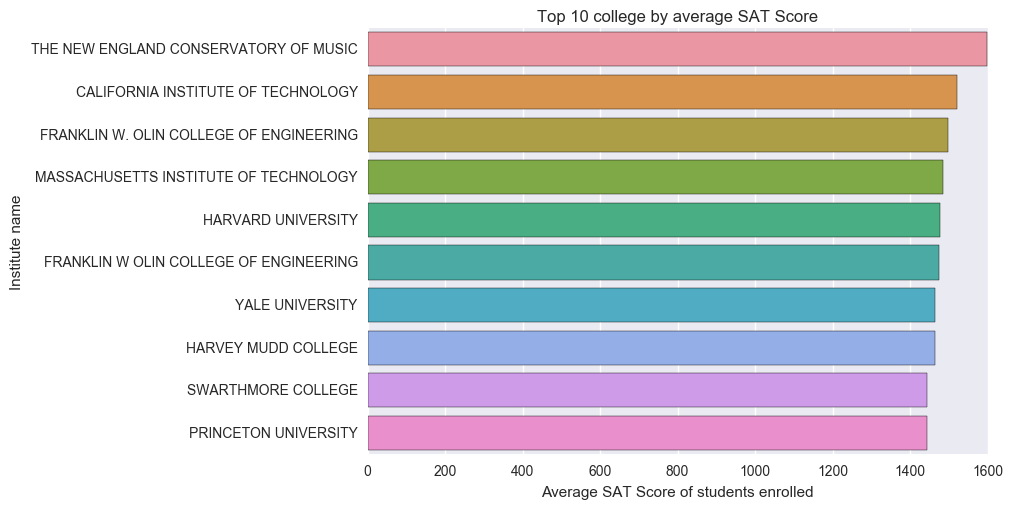

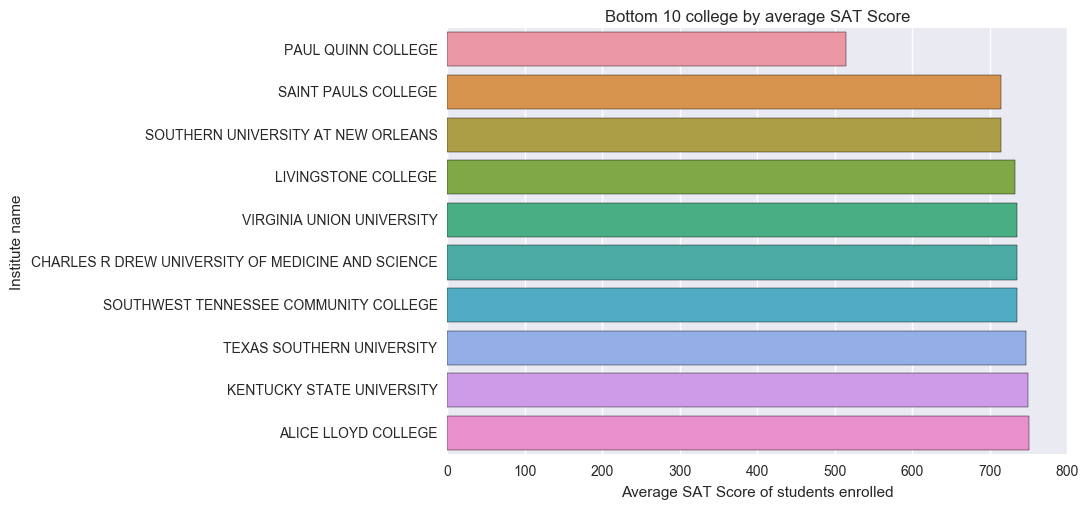

In [589]:
dff = df_copy.copy()
dff = dff[dff["SAT_AVG"] > 0]
dff["INSTNM"] = dff["INSTNM"].str.upper()
dff.drop_duplicates("INSTNM", inplace=True)
a = dff.sort_values('SAT_AVG', ascending=False).head(10)
sns.barplot(a["SAT_AVG"], a["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("Average SAT Score of students enrolled")
plt.title("Top 10 college by average SAT Score")
plt.show()

b = dff.sort_values('SAT_AVG', ascending=True).head(10)
sns.barplot(b["SAT_AVG"], b["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("Average SAT Score of students enrolled")
plt.title("Bottom 10 college by average SAT Score")
plt.show()

We can see that colleges/university like Harvard and Massachusetts institute of technology have students with relatively high SAT scores. This information are useful for students who wants to enter these college as to improve themselves in getting higher SAT scores to have a higher chance of getting in. <br><br>

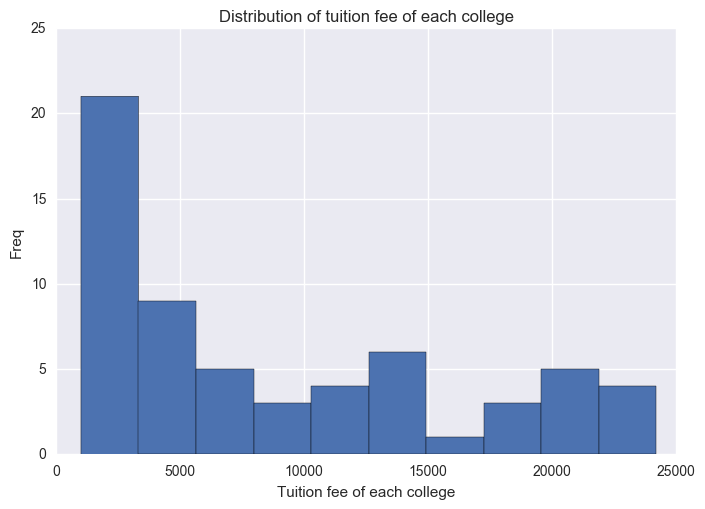

Variance:  0.100867562962
count       61.000000
mean      8812.262295
std       7426.826164
min       1000.000000
25%       3000.000000
50%       6000.000000
75%      14250.000000
max      24192.000000
Name: TUITIONFEE_PROG, dtype: float64


In [372]:
variable_to_check = "TUITIONFEE_PROG"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=10)
plt.xlabel("Tuition fee of each college")
plt.ylabel("Freq")
plt.title("Distribution of tuition fee of each college")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[variable_to_check]))) 
print(dfplt[variable_to_check].describe())

Looking in the histogram of distribution of tuition fee, we find that the tuition fee is relatively cheap for most college as the tuition fee for most colleges are below average the of $8812. <br><br>

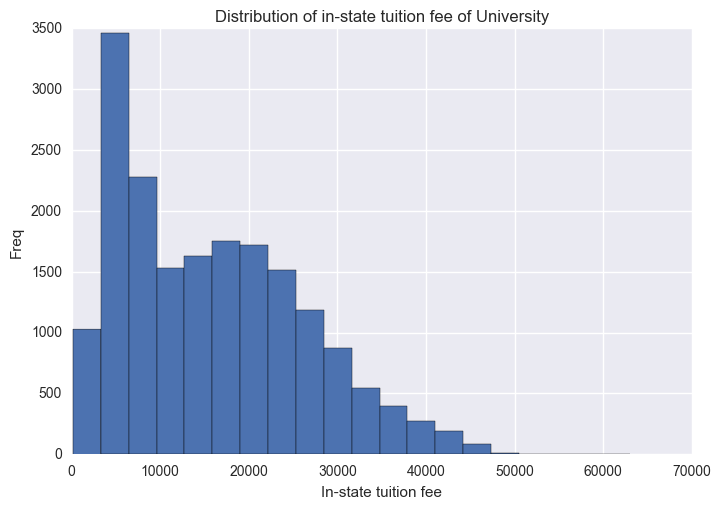

Variance:  0.026601632823
count    18467.000000
mean     15864.926897
std      10263.023581
min        150.000000
25%       6536.000000
50%      14530.000000
75%      23010.000000
max      63073.000000
Name: TUITIONFEE_IN, dtype: float64


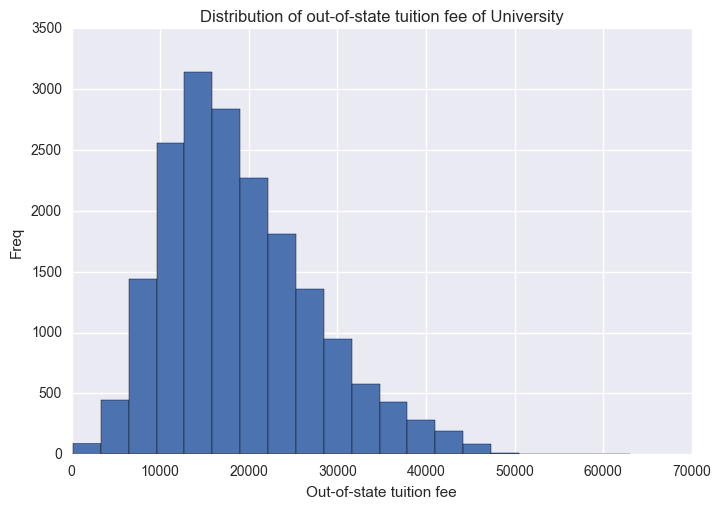

Variance:  0.0176559190025
count    18467.000000
mean     18939.291060
std       8361.156325
min        150.000000
25%      12828.000000
50%      17586.000000
75%      23915.500000
max      63073.000000
Name: TUITIONFEE_OUT, dtype: float64


In [688]:
variable_to_check = "TUITIONFEE_IN"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=20)
plt.xlabel("In-state tuition fee")
plt.ylabel("Freq")
plt.title("Distribution of in-state tuition fee of University")
plt.show()
print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[variable_to_check]))) 
print(dfplt[variable_to_check].describe())

variable_to_check = "TUITIONFEE_OUT"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=20)
plt.xlabel("Out-of-state tuition fee")
plt.ylabel("Freq")
plt.title("Distribution of out-of-state tuition fee of University")
plt.show()
print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[variable_to_check]))) 
print(dfplt[variable_to_check].describe())

There are only slight difference in tuition fee for in-state and out-of-state college.
Furthermore, the histogram shows that there are some outliers for both of the variable. We will take a deeper look into the variable before removing the outlier. <br><br>

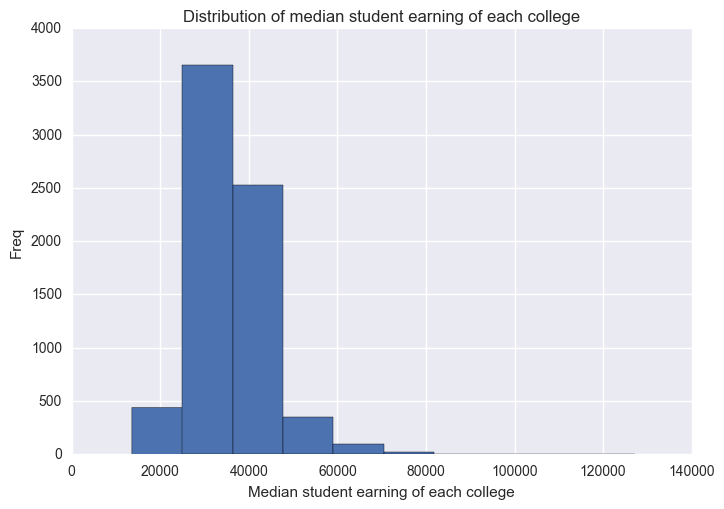

Variance:  0.00573183790663
count      7094.000000
mean      35880.969834
std        8608.708987
min       13600.000000
25%       30600.000000
50%       35000.000000
75%       39600.000000
max      127300.000000
Name: MD_EARN_WNE_P6, dtype: float64


In [376]:
variable_to_check = "MD_EARN_WNE_P6"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=10)
plt.xlabel("Median student earning of each college")
plt.ylabel("Freq")
plt.title("Distribution of median student earning of each college")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[variable_to_check]))) 
print(dfplt[variable_to_check].describe())

We can say that most students' salary after they graduate falls around 30k-40k. However, there are obvious outliers shown where the maximum median earning of that college's graduate is $127300. We will look into it to decide whether it is an error or not. 

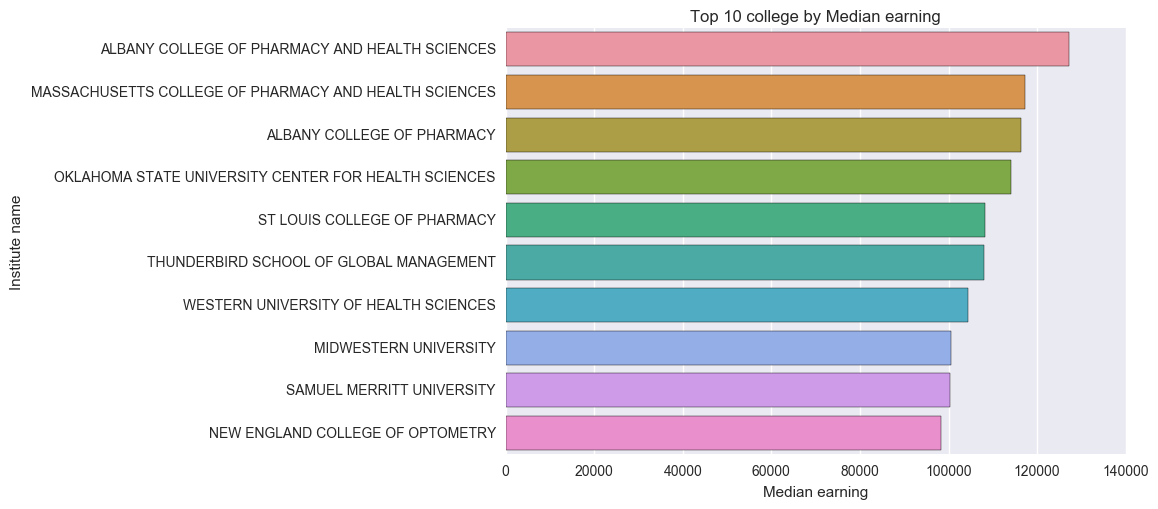

In [605]:
dff = df_copy.copy()
dff = dff[dff["MD_EARN_WNE_P6"] > 0]
dff["INSTNM"] = dff["INSTNM"].str.upper()
dff.drop_duplicates("INSTNM", inplace=True)
a = dff.sort_values('MD_EARN_WNE_P6', ascending=False).head(10)
sns.barplot(a["MD_EARN_WNE_P6"], a["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("Median earning")
plt.title("Top 10 college by Median earning")
plt.show()

The outlier isn't too significant, when compared side by side with the second highest using a barplot.
This barplot also tells us health sciences or pharmacy related may be one of the highest paying jobs in the US as the top 5 colleges are all related to health and pharmacy. Further analysis is required to prove the hypothesis. <br><br>

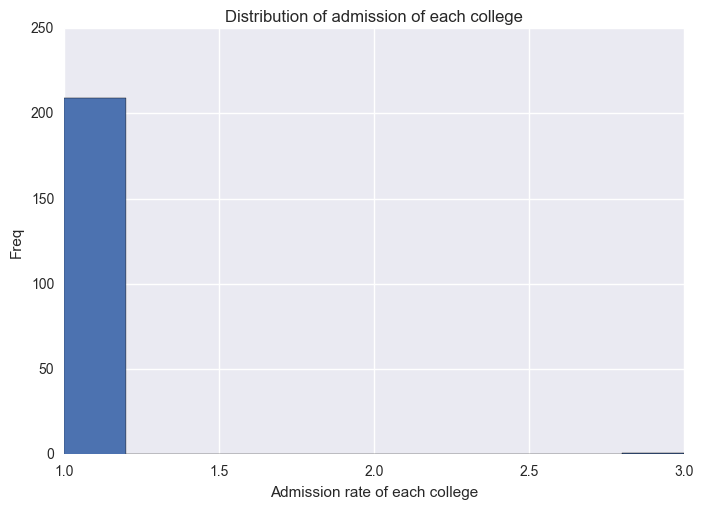

Rate of NaN:  98.8708463275621 %
Value count:
1.0    209
3.0      1
Name: ADM_RATE, dtype: int64

count    210.000000
mean       1.009524
std        0.138013
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: ADM_RATE, dtype: float64
Variance:  0.00473922902494


In [386]:
variable_to_check = "ADM_RATE"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check])
plt.xlabel("Admission rate of each college")
plt.ylabel("Freq")
plt.title("Distribution of admission of each college")
plt.show()
print("Rate of NaN: ", (len(df)-len(dfplt))/len(df)*100, "%")
print("Value count:")
print(dfplt[variable_to_check].value_counts())
print()
print(dfplt[variable_to_check].describe())
print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[variable_to_check]))) 

Over 98% of data from ADM_RATE are NaN values, and the variance is also relatively low which means majority of the data are the exact same. Hence we decided to ignore this feature, as it will not be useful in our analysis. <br><br>

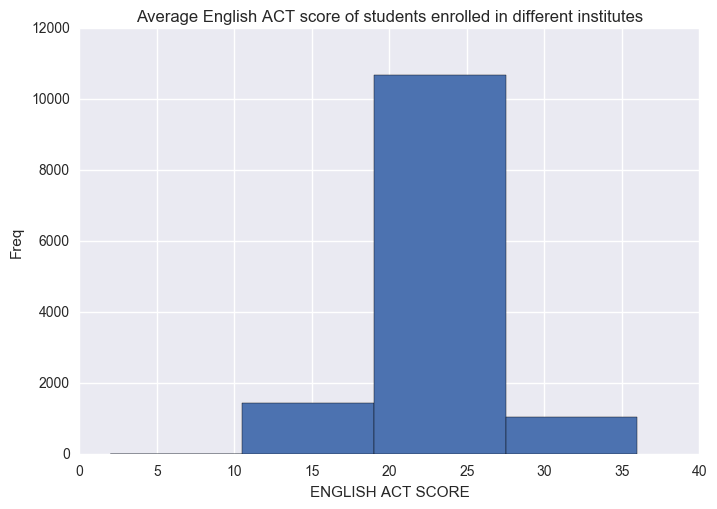

Variance:  0.0106555008313
count    13192.000000
mean        22.337553
std          3.509800
min          2.000000
25%         20.000000
50%         22.000000
75%         24.000000
max         36.000000
Name: ACTENMID, dtype: float64


In [691]:
variable_to_check = "ACTENMID"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=4)
plt.xlabel("ENGLISH ACT SCORE")
plt.ylabel("Freq")
plt.title("Average English ACT score of students enrolled in different institutes")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[variable_to_check]))) 
print(dfplt[variable_to_check].describe())

Each ACT test is scored out of 36 points, with the lowest possible score of 1. Hence there is nothing wrong with this feature. 
Majority of students have an average English ACT score of 22 points.

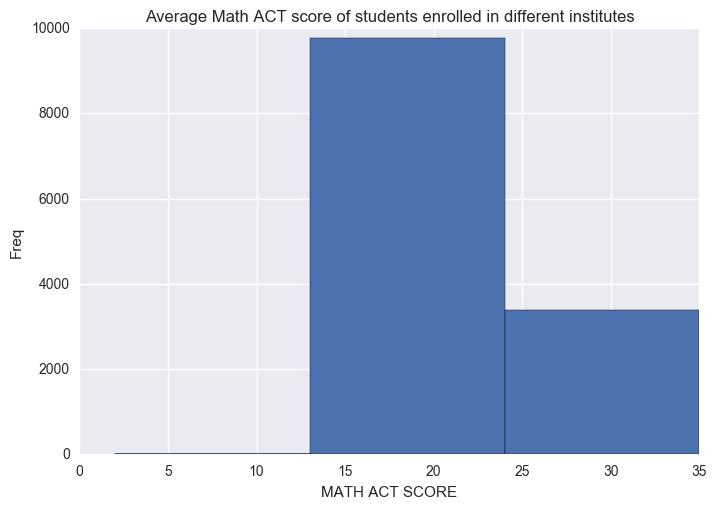

Variance:  0.0097038922902
count    13178.000000
mean        22.015025
std          3.250898
min          2.000000
25%         20.000000
50%         22.000000
75%         24.000000
max         35.000000
Name: ACTMTMID, dtype: float64


In [697]:
variable_to_check = "ACTMTMID"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=3)
plt.xlabel("MATH ACT SCORE")
plt.ylabel("Freq")
plt.title("Average Math ACT score of students enrolled in different institutes")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[variable_to_check]))) 
print(dfplt[variable_to_check].describe())

Each ACT test is scored out of 36 points, with the lowest possible score of 1.
Through the plot and looking into the data, there are one occurence where the SAT score for Math is only 1.
We decided that this is not an outlier, lowest possible score for an ACT test is 1.

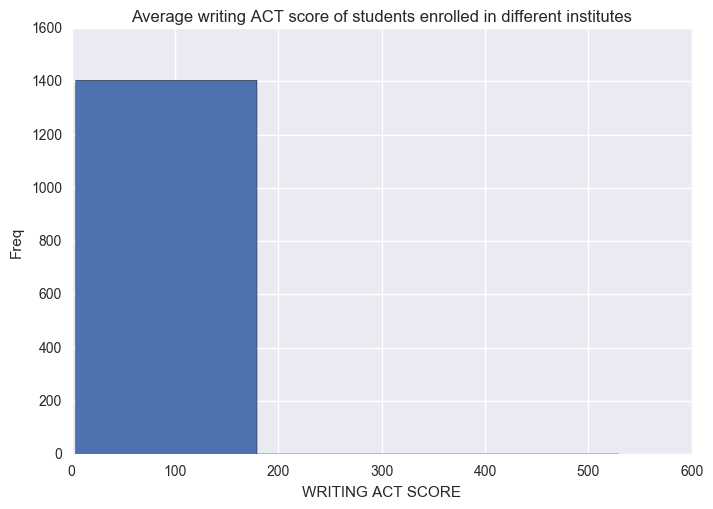

Variance:  0.000807184101564
count    1405.000000
mean       10.476868
std        14.949499
min         4.000000
25%         7.000000
50%         8.000000
75%         9.000000
max       530.000000
Name: ACTWRMID, dtype: float64


In [699]:
variable_to_check = "ACTWRMID"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=3)
plt.xlabel("WRITING ACT SCORE")
plt.ylabel("Freq")
plt.title("Average writing ACT score of students enrolled in different institutes")
plt.show()

print("Variance: ", np.var(min_max_scaler.fit_transform(dfplt[variable_to_check]))) 
print(dfplt[variable_to_check].describe())

Each ACT test is scored out of 36 points, with the lowest possible score of 1. There is an extreme outlier in this feature where the score is 530 where the minimum possible score is only 36. The row associated with it will be removed.

In [700]:
#Removing the outlier
df_copy = df_copy[(df_copy["ACTWRMID"] > 0) & (df_copy["ACTWRMID"] <= 36)]

After cleaning the ACT data, we want to see the top 10 institute with student of highest ACT score.

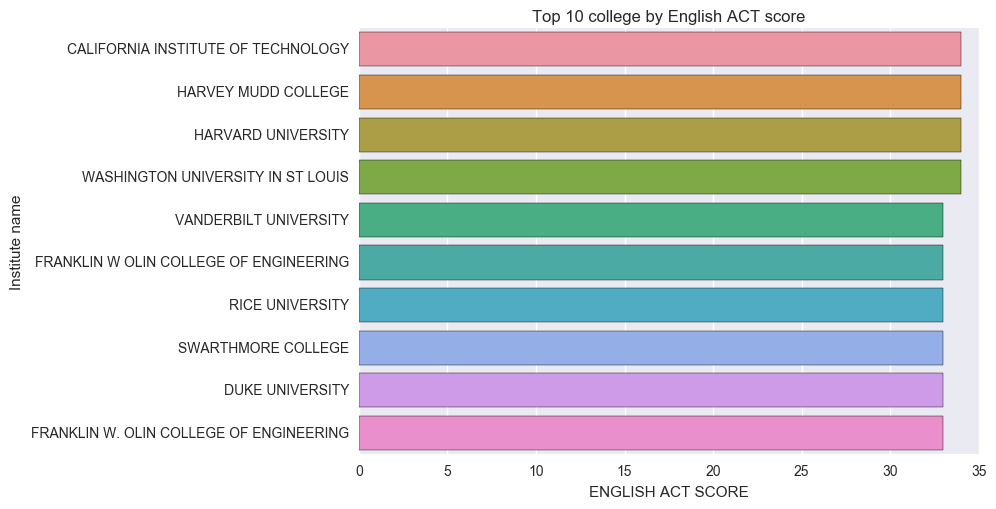

In [705]:
dff = df_copy.copy()
dff = dff[dff["ACTENMID"] > 0]
dff["INSTNM"] = dff["INSTNM"].str.upper()
dff.drop_duplicates("INSTNM", inplace=True)
a = dff.sort_values('ACTENMID', ascending=False).head(10)
sns.barplot(a["ACTENMID"], a["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("ENGLISH ACT SCORE")
plt.title("Top 10 college by English ACT score")
plt.show()

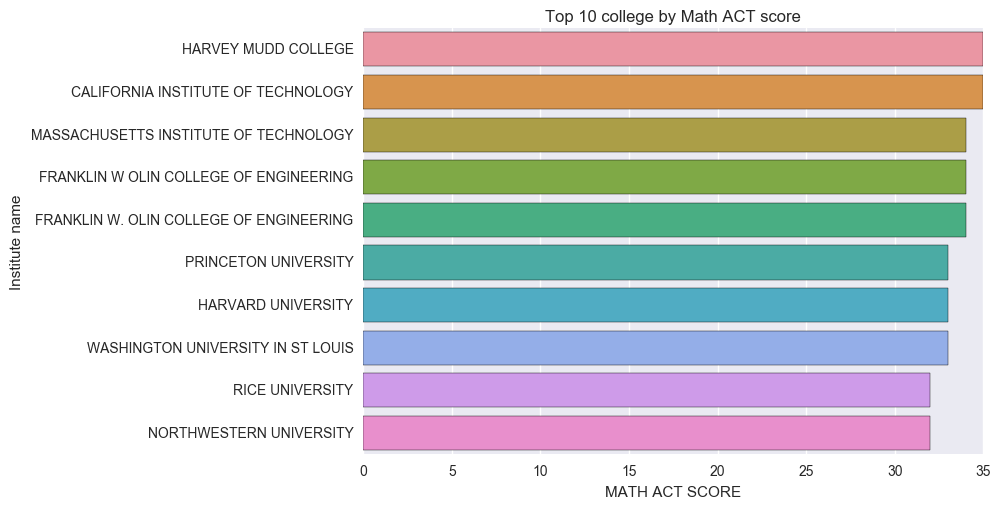

In [706]:
dff = df_copy.copy()
dff = dff[dff["ACTMTMID"] > 0]
dff["INSTNM"] = dff["INSTNM"].str.upper()
dff.drop_duplicates("INSTNM", inplace=True)
a = dff.sort_values('ACTMTMID', ascending=False).head(10)
sns.barplot(a["ACTMTMID"], a["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("MATH ACT SCORE")
plt.title("Top 10 college by Math ACT score")
plt.show()

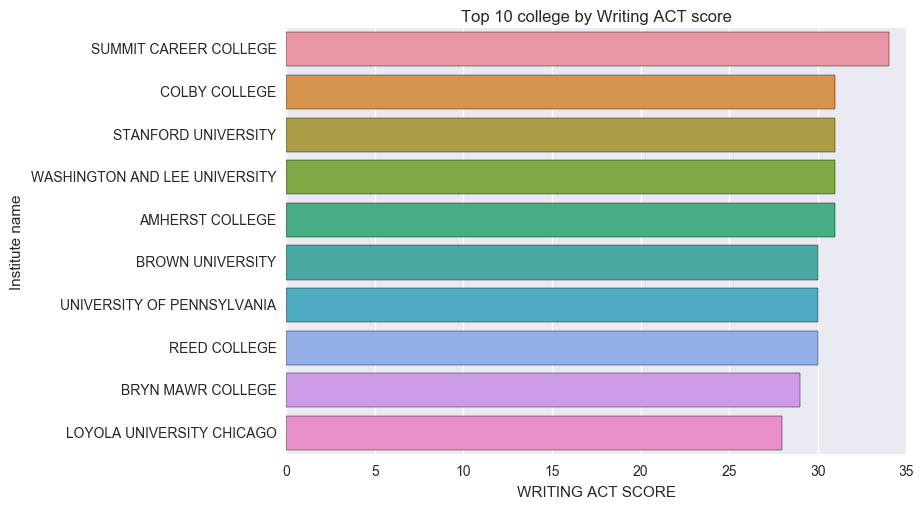

In [710]:
dff = df_copy.copy()
dff = dff[dff["ACTWRMID"] > 0]
dff["INSTNM"] = dff["INSTNM"].str.upper()
dff.drop_duplicates("INSTNM", inplace=True)
a = dff.sort_values('ACTWRMID', ascending=False).head(10)
sns.barplot(a["ACTWRMID"], a["INSTNM"], orient="h")
plt.ylabel("Institute name")
plt.xlabel("WRITING ACT SCORE")
plt.title("Top 10 college by Writing ACT score")
plt.show()

From these three barplots of the top 10 institute with highest ACT scores in writing, math, and English, we can say we are not surprised that institutes like MIT and harvard made it on the charts in Math and English ACT scores. <br><br>

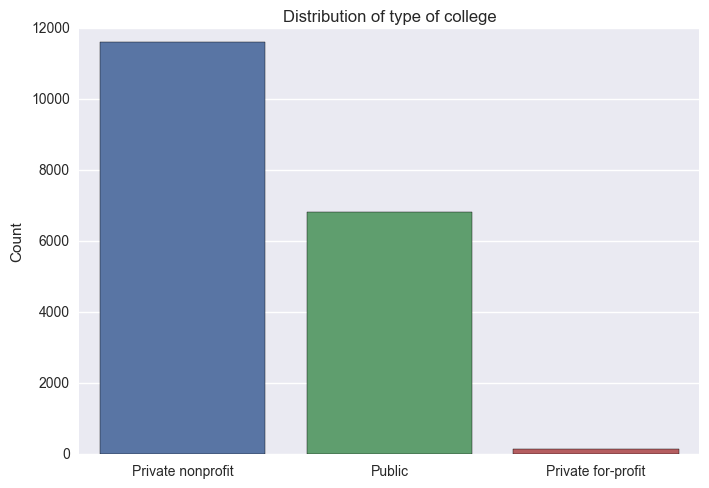

Private nonprofit     11615
Public                 6831
Private for-profit      152
Name: CONTROL, dtype: int64


In [359]:
variable_to_check = "CONTROL"
dfplt = df.copy()

sns.barplot( dfplt[variable_to_check].value_counts().index, dfplt[variable_to_check].value_counts() )
plt.ylabel("Count")
plt.title("Distribution of type of college")
plt.show()
print(dfplt[variable_to_check].value_counts())

From the distribution fo type of college, we can tell that most colleges in the US are private-nonprofit. While the minority are private for-profit. <br><br>

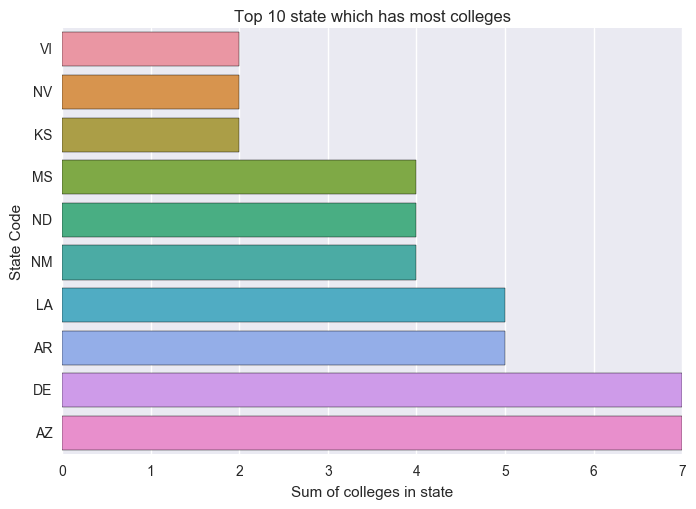

In [686]:
asd = df_copy.copy()
asd = asd[['INSTNM','STABBR']]
asdd = asd.groupby('STABBR').count().sort_values('INSTNM').head(10)

sns.barplot(asdd["INSTNM"] , asdd.index ,orient="h")
plt.ylabel("State Code")
plt.xlabel("Sum of colleges in state")
plt.title("Top 10 state which has most colleges")
plt.show()

From the graph, we know that which state has the highest number of colleges. We can conclude that Delaware has the highest number of college by refering to the graph. This enable us to know if we want to study, probably which state should we targeting at. <hr>

## Data Mining

After exploring the main characteristics of our data, we attempt to find patterns and relationships between features.

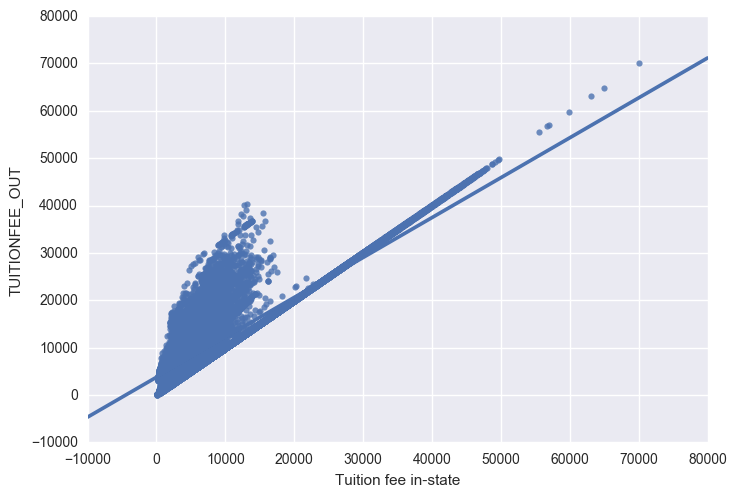

In [522]:
inout = df_copy.copy()
inout = inout[(inout.TUITIONFEE_IN > 0) & (inout.TUITIONFEE_OUT > 0)]
inout = inout[['TUITIONFEE_IN','TUITIONFEE_OUT','CONTROL']]
sns.regplot(inout.TUITIONFEE_IN,inout.TUITIONFEE_OUT,scatter=True,fit_reg=True)
plt.xlabel("Tuition fee in-state")
plt.ylabel("Tuition fee out-state")
plt.title("Comparison between the tuition fees in-state and out-state")
plt.show()

It looks like there are two set of data point, one where data points lie perfectly on line of x=y, which mean that both tution fee are the same for these institution. From this graph, we can conclude that some university might have a higher tuition fee for out-state students.

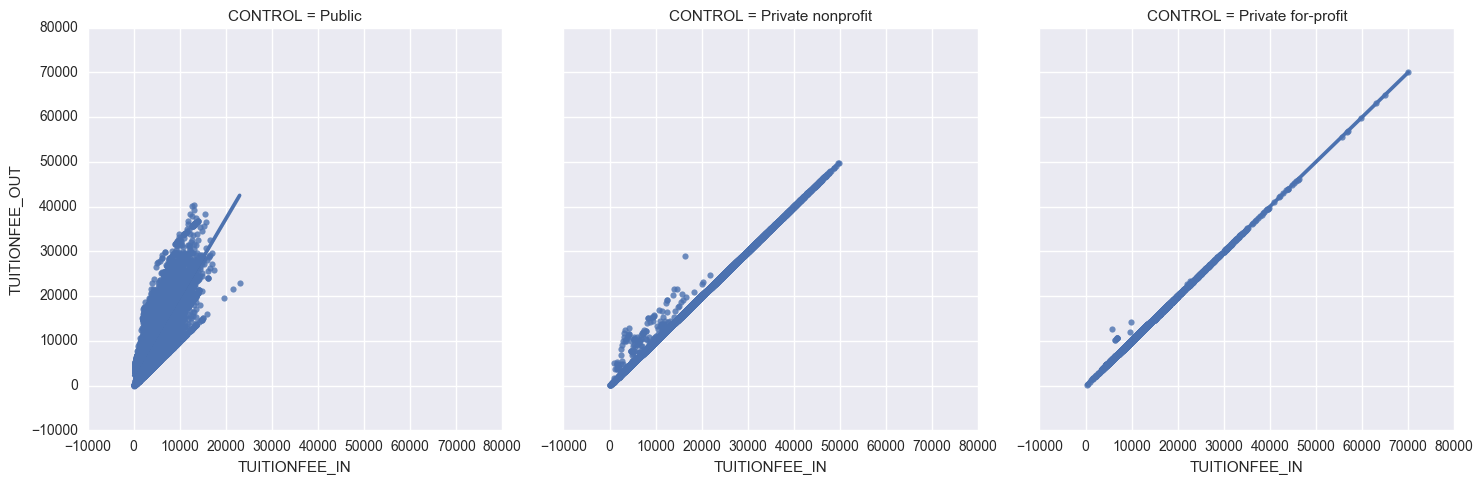

In [526]:
sns.lmplot(x="TUITIONFEE_IN",y="TUITIONFEE_OUT",col="CONTROL",data = inout,truncate=True)
plt.show()

From the graph above, we found out that around 30% of Private For-Profit and 55% of private non-profit share the same fee cost for both in and outstate study while only 5% of pulic institution share the same fee.
Plot shows how many point lie on the line


In [389]:
inout.groupby('CONTROL').mean()

,TUITIONFEE_IN,TUITIONFEE_OUT
CONTROL,,
Private for-profit,12866.961431,12870.163045
Private nonprofit,17554.040965,17580.530117
Public,3544.328542,8433.536785


After analysis for all of the institution, we further our analysis to calculate the mean for both in and outstate tution fee cost.There is almost no in-state out-state fee difference for private instituions while for public institutions the out state fee is approximate twice compare with instate fee. <br><br>

In [592]:
asd = df_copy.copy()
asd = asd[asd['UNEMP_RATE']>0]
asd = asd[['INSTNM','STABBR','UNEMP_RATE',]]
asd["INSTNM"] = asd["INSTNM"].str.upper()
asd = asd.sort_values('UNEMP_RATE',ascending=False)
asd.drop_duplicates("INSTNM", inplace=True)
asd.head(5)

,INSTNM,STABBR,UNEMP_RATE
12221,STONE CHILD COLLEGE,MT,15.0
6874,ALASKA VOCATIONAL TECHNICAL CENTER,AK,15.0
35414,BLACKFEET COMMUNITY COLLEGE,MT,14.0
12704,UNITED EDUCATION AND COMPUTER COLLEGE,CA,13.0
24102,OGLALA LAKOTA COLLEGE,SD,12.0


From the table, we are able to find out the institute with the top 5 highest unemployment rate, these are probably the college that we gonna avoid as we would want a low unemployment rate college.

## Which sector of ACT scores contributes the most to the income of graduate?
_We will go deeper into it in our linear regression model_

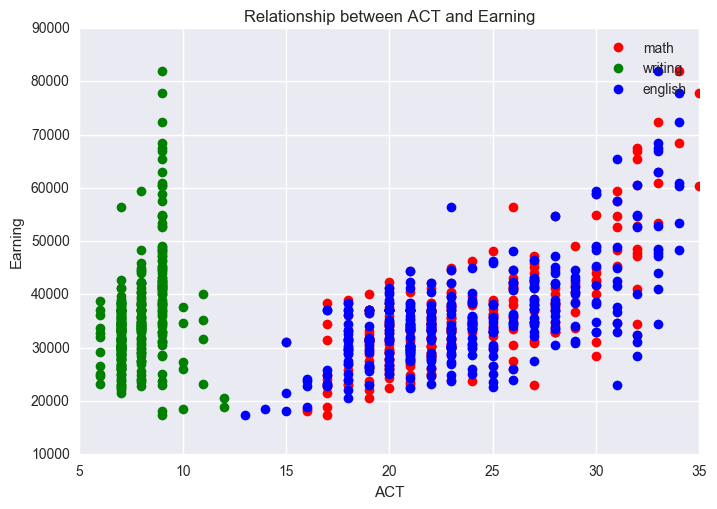

In [590]:
dfplt = df.copy()
dfplt = dfplt[(dfplt.ACTENMID > 0)  & (dfplt.ACTMTMID > 0) & (dfplt.ACTWRMID > 0) & (dfplt['MD_EARN_WNE_P6']>0)]
math = plt.plot(dfplt['ACTMTMID'], dfplt.MD_EARN_WNE_P6, 'ro', label = "math")
writing = plt.plot(dfplt['ACTWRMID'], dfplt.MD_EARN_WNE_P6, 'go', label = "writing")
english = plt.plot(dfplt['ACTENMID'], dfplt.MD_EARN_WNE_P6, 'bo', label = "english")
plt.title("Relationship between ACT and Earning")
plt.xlabel("ACT")
plt.ylabel("Earning")
plt.legend()
plt.show()

From the graph above, we can know that ACT scores might have a significant affect in determine the future earning. 
Hence for now, maybe it is suitable in training our predictive model.

## Does SAT score affect the income of graduate?

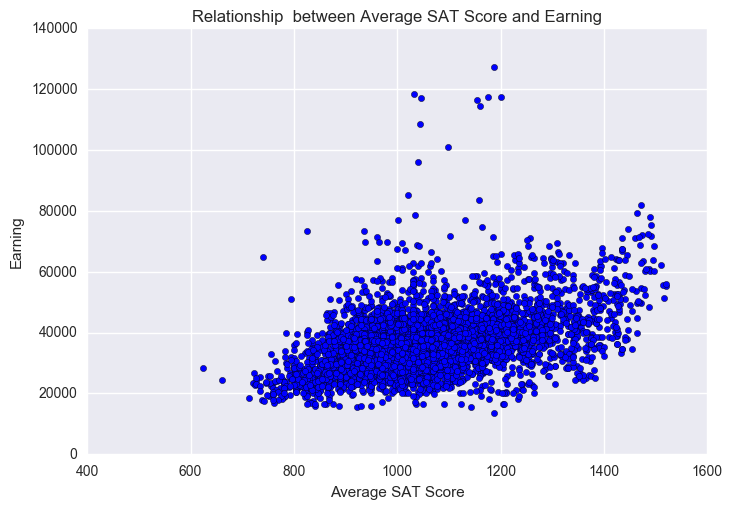

In [529]:
Sat_6yEarn = df_copy[(df_copy.SAT_AVG > 0) & (df_copy.MD_EARN_WNE_P6 > 0) ]
plt.scatter(Sat_6yEarn['SAT_AVG'], Sat_6yEarn['MD_EARN_WNE_P6'])
plt.xlabel('SAT_AVG')
plt.ylabel('MD_EARN_WNE_P6')
plt.title("Relationship  between Average SAT Score and Earning")
plt.xlabel("Average SAT Score")
plt.ylabel("Earning")
plt.show()

#clearly an increasing sign

From the graph above, we can know that the SAT score might affect the earning, but the plot is not that significant and contains some outliers.

## Does tuition fee affect the income  of graduate?

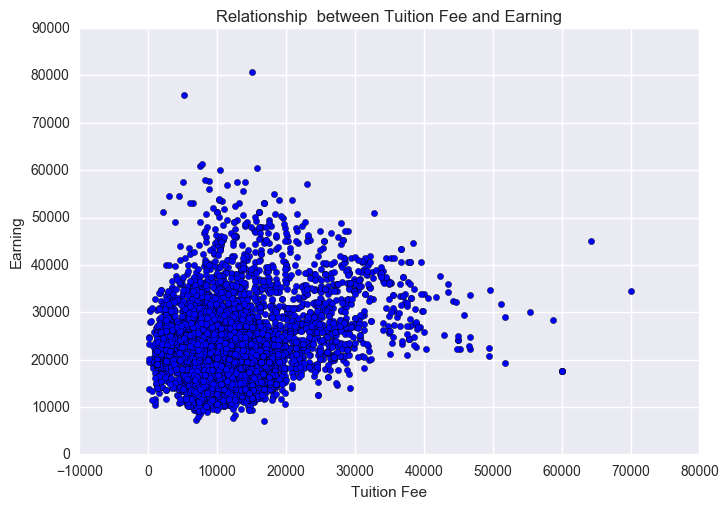

In [393]:
#find if Tuition fee affect Earning
Tui_6yEarn = df_copy[(df_copy.TUITIONFEE_PROG > 0) & (df_copy.MD_EARN_WNE_P6 > 0) ]
plt.scatter(Tui_6yEarn['TUITIONFEE_PROG'], Tui_6yEarn['MD_EARN_WNE_P6'])
plt.xlabel('Tuition Fee')
plt.ylabel('Earning')
plt.title("Relationship  between Tuition Fee and Earning")
plt.show()
#not quite, and hard to see as most of the tuition fee fall in the lower range

From the graph above, we can know that tuition fee might not really affect the earning of graduates
This is probably due to most college has the same range of tuition fees like the descriptive analysis that we found out ealier.

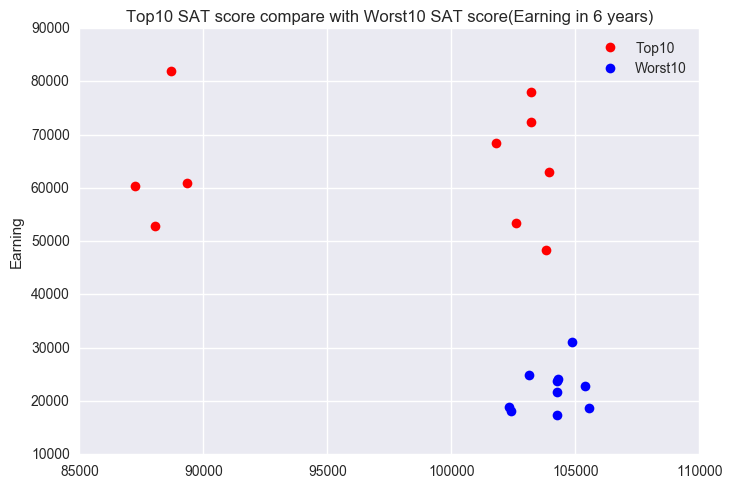

In [509]:
Sat3_6yEarn = df_copy[(df_copy.ACTENMID > 0)  & (df_copy.ACTMTMID > 0) & (df_copy.ACTWRMID > 0) & (df_copy.MD_EARN_WNE_P6 > 0) ]
acs = Sat3_6yEarn.sort_values(['ACTENMID', 'ACTMTMID', 'ACTWRMID'], ascending = False).head(10)
des = Sat3_6yEarn.sort_values(['ACTENMID', 'ACTMTMID', 'ACTWRMID'], ascending = True).head(10)
top = plt.plot(acs['MD_EARN_WNE_P6'],'ro', label="Top10")
btn = plt.plot(des['MD_EARN_WNE_P6'],'bo', label="Worst10")  

plt.title("Top10 SAT score compare with Worst10 SAT score(Earning in 6 years)")
plt.legend()
plt.ylabel('Earning')
plt.show()
#red mean the top 10 SAT score in read, writing and english
#blue mean the least 10 SAT score in read, writing and english
#clearly we can know that red earn high than blue

SAT scores might affect the earnings of graduates. Although due to the unsignificant increase, we cant really construct a predictivve model based on it, but it can still be used as a factor in deciding the college that you should enroll.
We try to plot the comparison between the top 10 SAT score college and the worst 10 SAT score college in term of earning.

## Does studying in public college earns more than studying in private college?

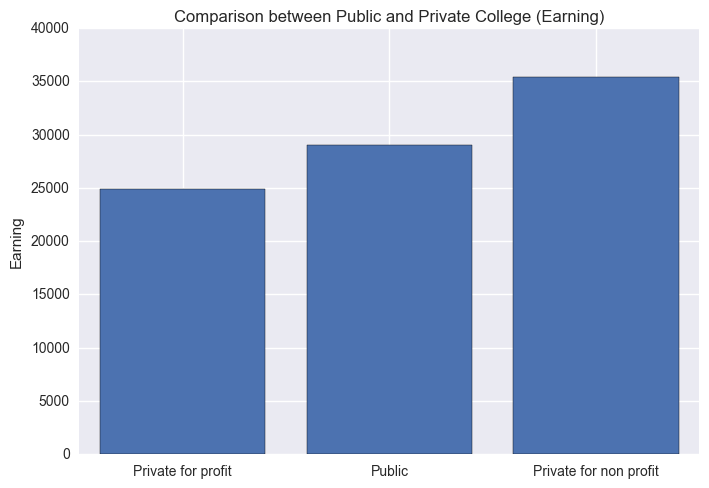

In [328]:
public = df_copy[(df_copy.CONTROL == 'Public')]
private_np = df_copy[(df_copy.CONTROL == 'Private nonprofit')]
private_p = df_copy[(df_copy.CONTROL == 'Private for-profit')]
public = public[public.MD_EARN_WNE_P6 > 0]
private_np = private_np[private_np.MD_EARN_WNE_P6 > 0]
private_p = private_p[private_p.MD_EARN_WNE_P6 > 0]
x = sum(public['MD_EARN_WNE_P6'])/len(public)
y = sum(private_np['MD_EARN_WNE_P6'])/len(private_np)
z = sum(private_p['MD_EARN_WNE_P6'])/len(private_p)
dictionary = plt.figure()

D = {u'Public':x, u'Private for non profit': y, u'Private for profit':z}

plt.title("Comparison between Public and Private College (Earning)")
plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())
plt.ylabel('Earning')
plt.show()

The graph gives us a basic idea on which type of college might have a higher earning after graduate. From the graph above, we can conclude that enroll in the private for non profit college will most probably earn a higher income. <hr>

# Linear Regression

We try to build a linear regression model based on the ACT score to predict the future income level. The reason we choose ACT score is due to that we found out ACT might be showing significant effect on determine the income of the graduates.

Estimated intercept 3
    Subject          est
0  ACTENMID -1189.144312
1  ACTMTMID  2910.042421
2  ACTWRMID    -3.014084


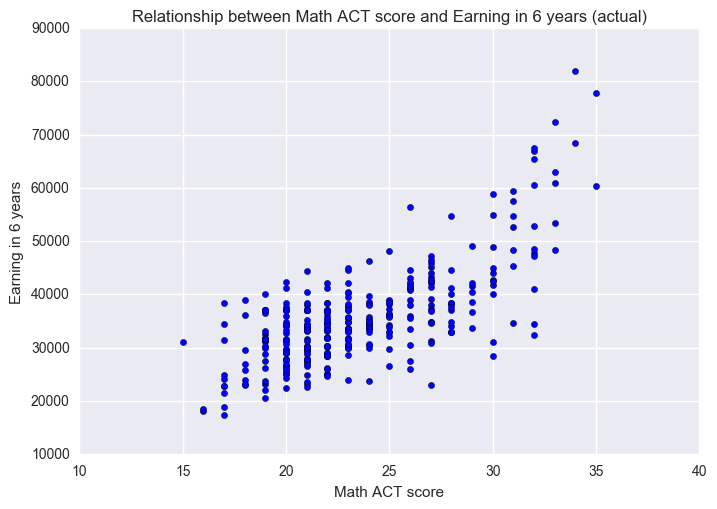

In [545]:
linear_data = df_copy.copy()
linear_data = linear_data[(linear_data.ACTENMID > 0)  & (linear_data.ACTMTMID > 0) & (linear_data.ACTWRMID > 0) & (linear_data['MD_EARN_WNE_P6']>0)]
linear_data = linear_data[['ACTENMID', 'ACTMTMID', 'ACTWRMID','MD_EARN_WNE_P6']]

from sklearn.linear_model import LinearRegression
x = linear_data.drop('MD_EARN_WNE_P6' , axis = 1)
lm = LinearRegression()
lm.fit(x,linear_data.MD_EARN_WNE_P6)

print ('Estimated intercept', len(lm.coef_))
a = pd.DataFrame(list(zip(x.columns, lm.coef_)), columns = ['Subject', 'est'])
print(a)
#since ACT math is the highest coeficient, hence we plot ACT math

plt.scatter(linear_data.ACTMTMID, linear_data.MD_EARN_WNE_P6)
plt.xlabel("Math ACT score")
plt.ylabel("Earning in 6 years")
plt.title("Relationship between Math ACT score and Earning in 6 years (actual)")
plt.show()

From the a dataframe above, we can conclude that math might have a highest coeficient, hence we want to look at only Math ACT score instead of all ACT score like the one we did above. Since math ACT score has the highest coeficient, we might train our model based on Math ACT score or combining the three ACT score to train our model. We will decide based on their performance later on.

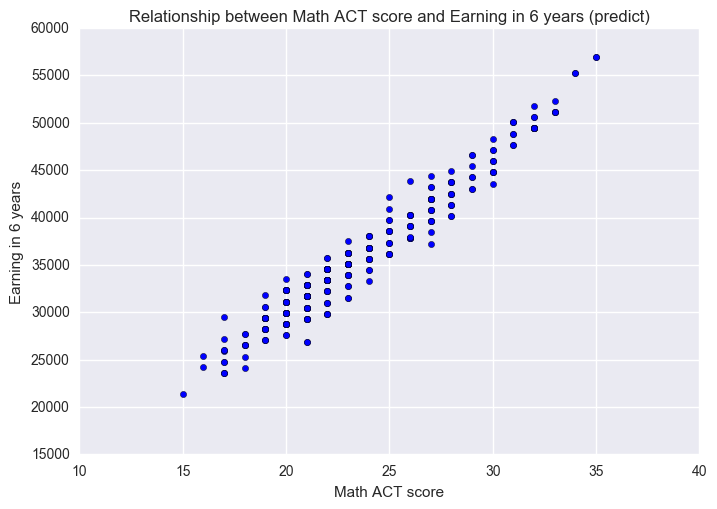

In [546]:
lm.predict(x)[0:328]
plt.scatter(linear_data.ACTMTMID, lm.predict(x))
plt.xlabel("Math ACT score")
plt.ylabel("Earning in 6 years")
plt.title("Relationship between Math ACT score and Earning in 6 years (predict)")
plt.show()

We try to see the relationship between Math ACT score and earning after applying the predictive model to see if it has a big difference with the actual one or not.

In [579]:
y = linear_data.drop(['MD_EARN_WNE_P6'] , axis = 1)
lm = LinearRegression()
lm.fit(y[['ACTMTMID']],linear_data.MD_EARN_WNE_P6)

msemath = np.mean((linear_data.MD_EARN_WNE_P6 - lm.predict(y[['ACTMTMID']])) ** 2)
print("Math mean square error = ", msemath)

lm.fit(y,linear_data.MD_EARN_WNE_P6)
msefull = np.mean((linear_data.MD_EARN_WNE_P6 - lm.predict(y)) ** 2)
print("Full mean square error = ", msefull)

Math mean square error =  42463329.15538637
Full mean square error =  40171339.622049525


input 3 values perform better, hence we will try to build our model by considering both 3 ACT values

In [580]:
import sklearn.cross_validation
x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(x, linear_data.MD_EARN_WNE_P6, test_size = 0.33, random_state = 5)
print(x_train.shape)
print(x_test.shape) 
print(y_train.shape)
print(y_test.shape)

(219, 3)
(109, 3)
(219,)
(109,)


We try to split the data into training and test set. Then, we find the shape of the training and testing to make sure our training and testing dataset is ready.

In [513]:
lm = LinearRegression()
lm.fit(x_train, y_train)
pred_train = lm.predict(x_train)
pred_test = lm.predict(x_test)

We try to train our model based on all the ACT scores as we found out that by involving all the ACT scores, we can get a lower mean square error.

In [535]:
print("Train mean square error:", np.mean((y_train - lm.predict(x_train)) ** 2))
print("Test mean square error:", np.mean((y_test - lm.predict(x_test)) ** 2))

Train mean square error: 39306101.81356143
Test mean square error: 41909753.20057145


We try to see the mean square error for both train and test set.

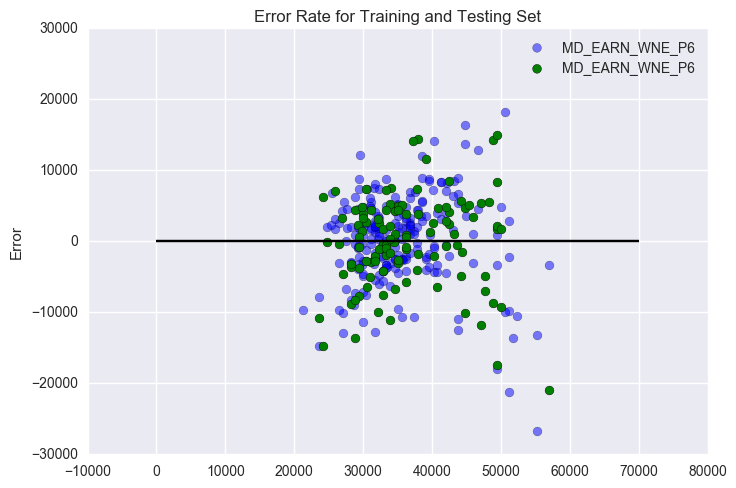

In [582]:
plt.scatter(lm.predict(x_train),lm.predict(x_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(x_test),lm.predict(x_test) - y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 70000)
plt.title('Error Rate for Training and Testing Set')
plt.ylabel('Error')
plt.legend()
plt.show()

#most of it scatter around 0, good!

We try to plot our the error rate for training and testing set. According to the graph, when the plot is nearer to 0, it mean that it contain a smaller range of error. Hence the graph shown that all the plot is around the 0 line, which is a very good sign.

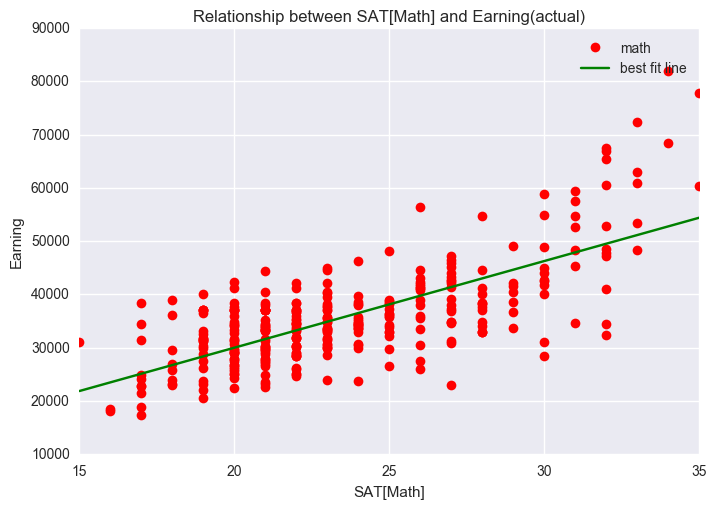

In [584]:
from sklearn import linear_model
import numpy as np
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)
pred_test = lm.predict(x_test)
fit = np.polyfit(x['ACTMTMID'],linear_data.MD_EARN_WNE_P6,1)
p = np.poly1d(fit)

#since we know math has highest corelation, try to fit and compare using it
math = plt.plot(x['ACTMTMID'], linear_data.MD_EARN_WNE_P6, 'ro', label = "math")
xp = np.linspace(15, 35, 50)
best_fit = plt.plot(xp, p(xp), '-', color='green', label="best fit line")

plt.title("Relationship between SAT[Math] and Earning(actual)")
plt.xlabel("SAT[Math]")
plt.ylabel("Earning")
plt.legend()
plt.show()

Since we know that math has the highest coeficient, we try to plot out the best fit for math to just have an idea of how our linear regression work so that we will have confidence in our model. The graph above shows the original dataset and its best fit line, we will then use this to compare with our predict model to see if it has any significant difference.

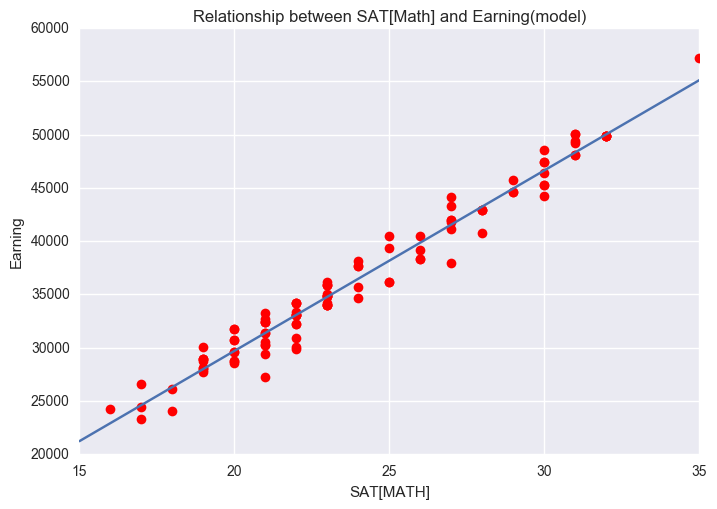

In [518]:
fit = np.polyfit(x_test['ACTMTMID'],lm.predict(x_test),1)
p = np.poly1d(fit)

plt.plot(x_test['ACTMTMID'], lm.predict(x_test), 'ro')
xp = np.linspace(15, 35, 50)
orange = plt.plot(xp, p(xp), '-')

plt.title("Relationship between SAT[Math] and Earning(model)")
plt.xlabel("SAT[MATH]")
plt.ylabel("Earning")
plt.show()

The graph above shows the best fit line of our model when applied to test set, the difference is not that significant so it prove that our linear regression is logical through comparing the both graph visualization.

In [519]:
print("Mean square error for the model is:", np.mean((y_test - lm.predict(x_test)) ** 2)) 
print("The estimated coeficient of English is: ", lm.coef_[0])
print("The estimated coeficient of Math is: ", lm.coef_[1])
print("The estimated coeficient of Writing is: ", lm.coef_[2])

Mean square error for the model is: 42488041.97791104
The estimated coeficient of English is:  -1076.09957108
The estimated coeficient of Math is:  2811.35207771
The estimated coeficient of Writing is:  223.65933888


We want to once find out the mean square error for the model when applied to test set and the coeficient of all our attributes that are used to train our dataset.

In [520]:
print(lm.predict([30,30,11]))

[ 47890.72193148]


We try to predict an income based on the ACT scores, the result is logical and it prove that our model should be working in guessing the future income.